# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

from nltk import SnowballStemmer

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
# -- YOUR CODE HERE --
print(train.isna().sum().sum(), test.isna().sum().sum())
train.fillna('', inplace=True)
test.fillna('', inplace=True)
print(train.isna().sum().sum(), test.isna().sum().sum())

1804 790
0 0


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [6]:
# -- YOUR CODE HERE --
train.target.value_counts()

target
0    3024
1    2305
Name: count, dtype: int64

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

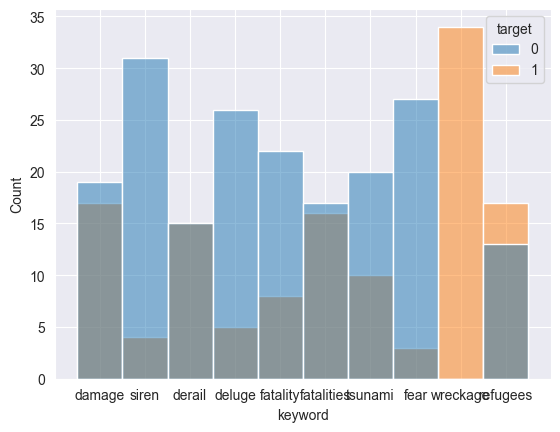

In [7]:
train.keyword.value_counts()[1:11].keys()
train_popular_keywords = train[train['keyword'].isin(train.keyword.value_counts()[1:11].keys())][['keyword', 'target']]
sns.histplot(train_popular_keywords, x='keyword', hue='target')
sns.set(rc={'figure.figsize': (12, 8)})

**Выводы**: Слова siren, deluge, fatality, tsunami, fear чаще всего сигнализируют нам о нулевом классе. Слово wreckage однозначно указывает на первый класс. Слово refugees чаще всего указывает на первый класс. Остальные же слова, почти равномерно относятся как к первому так и ко второму классам.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [8]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [9]:
# -- YOUR CODE HERE --
train_new = pd.DataFrame()
train_new['text'] = train[['keyword', 'location', 'text']].agg(' '.join, axis=1)
train_new['target'] = train['target']

test_new = pd.DataFrame()
test_new['text'] = test[['keyword', 'location', 'text']].agg(' '.join, axis=1)
test_new['target'] = test['target']
train_new

,text,target
1186,bridge%20collapse Ashes 2015: AustraliaÛªs c...,0
4071,"hail Carol Stream, Illinois GREAT MICHIGAN TEC...",1
5461,police Houston CNN: Tennessee movie theater s...,1
5787,rioting Still rioting in a couple of hours le...,1
7445,wounds Lake Highlands Crack in the path where ...,0
...,...,...
5226,obliteration Merica! @Eganator2000 There aren'...,0
5390,panic just had a panic attack bc I don't have...,0
860,blood Omron HEM-712C Automatic Blood Pressure...,0
7603,Officials say a quarantine is in place at an...,1


In [10]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# -- YOUR CODE HERE --
vectorizer = CountVectorizer()
train_new_vectorised = vectorizer.fit_transform(train_new['text'])
print('Размер матрицы', *train_new_vectorised.shape)


Размер матрицы 5329 18455


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [12]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    # -- YOUR CODE HERE --
    return any(i.isdigit() for i in s)

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    # -- YOUR CODE HERE --
    return any(i in punctuation for i in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    # -- YOUR CODE HERE --
    return s[0] == '#'

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    # -- YOUR CODE HERE --
    return s[0] == '@'

def investigate_vocabulary(vocabulary):
    # -- YOUR CODE HERE --
    print('With digit:      ', # -- YOUR CODE HERE -- 
          sum(map(contains_digit, vocabulary)))
    print('With punctuation:', # -- YOUR CODE HERE --
          sum(map(contains_punctuation, vocabulary)))
    print('Hashtags:        ', # -- YOUR CODE HERE --
          sum(map(is_hashtag, vocabulary)))
    print('Mentions:        ', # -- YOUR CODE HERE --
          sum(map(is_mention, vocabulary)))




In [13]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)


With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [14]:
investigate_vocabulary(# -- YOUR CODE HERE --
                       vectorizer.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [15]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer
# help(tokenizer)

In [16]:
# -- YOUR CODE HERE --
tokenizer = TweetTokenizer()
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize)
vectorizer.fit_transform(train_new.text)
# vectorizer.vocabulary_

C:\Users\Амир\PROGRAMMING\input v tink\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x19670 sparse matrix of type '<class 'numpy.int64'>'
	with 94563 stored elements in Compressed Sparse Row format>

In [17]:
investigate_vocabulary(# -- YOUR CODE HERE --
                       vectorizer.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** После добавления TweetTokenizer, CountVectorizer начал выделять упоминания и хэштэги. Кроме этого, в целом, выросли все показатели, в том числе выросло количество слов с числами и пунктуацией. 

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [18]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    # -- YOUR CODE HERE --
    return all('a' <= i <= 'z' or 'A' <= i <= 'Z'  for i in s)

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    # -- YOUR CODE HERE --
    return any(i == '(' or i ==')' for i in s) and all(i in punctuation for i in s)
    

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    # -- YOUR CODE HERE --
    return s[0] == '#' and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    # -- YOUR CODE HERE --
    s = s.lower()
    tokenizer = TweetTokenizer()
    s = tokenizer.tokenize(s)
    only_latin = []
    for token in s:
        if contains_only_latin_letters(token) or is_emoji(token) or is_hashtag(token):
            only_latin.append(token)
    stemmer = SnowballStemmer('english')
    stems = [stemmer.stem(word) for word in only_latin]
    return stems
    
  

In [19]:
custom_tokenizer('She LOVES painting :-) #art')

['she', 'love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [20]:
# -- YOUR CODE HERE --
top_10 = np.array(train_new.text.head(10))
for i in top_10:
    print(custom_tokenizer(i))

['bridg', 'ash', 'australia', 'collaps', 'at', 'trent', 'bridg', 'among', 'worst', 'in', 'histori', 'england', 'bundl', 'out', 'australia', 'for']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', 'to', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'by', 'polic']
['riot', 'still', 'riot', 'in', 'a', 'coupl', 'of', 'hour', 'left', 'until', 'i', 'have', 'to', 'be', 'up', 'for', 'class']
['wound', 'lake', 'highland', 'crack', 'in', 'the', 'path', 'where', 'i', 'wipe', 'out', 'this', 'morn', 'dure', 'beach', 'run', 'surfac', 'wound', 'on', 'left', 'elbow', 'and', 'right', 'knee']
['airplan', 'somewher', 'out', 'there', 'expert', 'in', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'on', 'reunion', 'island', 'french', 'air', 'accid', 'expert', 'on', '#mlb']
['bloodi', 'isol', 'citi', 'in', 'world', 'perth', 'i', 'came', 'to', 'kill', 'indian', 'for', 'fun', 'video', 'of', 'smirk

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [21]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
# -- YOUR CODE HERE --
train_vectorised = vectorizer.fit_transform(train_new.text) 
test_vectorised = vectorizer.transform(test_new.text) 

In [22]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       0
With punctuation: 1334
Hashtags:         1323
Mentions:         0


2. Обучите LogisticRegression на полученных признаках.


In [23]:
from sklearn.linear_model import LogisticRegression
# -- YOUR CODE HERE --
lr = LogisticRegression()
lr.fit(train_vectorised, train_new.target)

LogisticRegression()

3. Посчитайте метрику f1-score на тестовых данных.

In [24]:
from sklearn.metrics import f1_score

# -- YOUR CODE HERE --
pred = lr.predict(test_vectorised)
print(f1_score(test_new.target, pred))

0.7592493297587132


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
# -- YOUR CODE HERE --
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
train_tfidf = vectorizer.fit_transform(train_new.text)
test_tfidf = vectorizer.transform(test_new.text)
lr.fit(train_tfidf, train_new.target)
pred = lr.predict(test_tfidf)
print(f'F1 score {f1_score(test_new.target, pred)}')
print('Размеры матриц')
print(train_tfidf.shape)
print(test_tfidf.shape)

C:\Users\Амир\PROGRAMMING\input v tink\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score 0.74434014356709
Размеры матриц
(5329, 10597)
(2284, 10597)


1. **Ответ:** Качество немного упало

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [26]:
# 2
# -- YOUR CODE HERE --
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
train_tfidf = vectorizer.fit_transform(train_new.text)
test_tfidf = vectorizer.transform(test_new.text)
lr.fit(train_tfidf, train_new.target)
pred = lr.predict(test_tfidf)
print(f'F1 score {f1_score(test_new.target, pred)}')

C:\Users\Амир\PROGRAMMING\input v tink\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score 0.74434014356709


In [27]:
# -- YOUR CODE HERE --
print('Размеры матриц')
print(train_tfidf.shape)
print(test_tfidf.shape)

Размеры матриц
(5329, 10597)
(2284, 10597)


2. **Ответ:** Качество, как и размеры матриц, не изменилось

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [28]:
# 3
# -- YOUR CODE HERE --
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer,min_df=0.0009,  max_df=0.9)
train_tfidf = vectorizer.fit_transform(train_new.text)
test_tfidf = vectorizer.transform(test_new.text)
lr.fit(train_tfidf, train_new.target)
pred = lr.predict(test_tfidf)
print(f'F1 score {f1_score(test_new.target, pred)}')
print('Размеры матриц')
print(train_tfidf.shape)
print(test_tfidf.shape)

C:\Users\Амир\PROGRAMMING\input v tink\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score 0.7483516483516484
Размеры матриц
(5329, 2140)
(2284, 2140)


3. **Ответ:** Удалось немного улучшить качество и ощутимо снизить размеры матриц.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [29]:
from sklearn.feature_extraction.text import HashingVectorizer

# -- YOUR CODE HERE --
vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
train_hashed = vectorizer.fit_transform(train_new.text)
test_hashed = vectorizer.transform(test_new.text)
lr.fit(train_hashed, train_new.target)
pred = lr.predict(test_hashed)
print(f'F1 score {f1_score(test_new.target, pred)}')
print('Размеры матриц')
print(train_hashed.shape)
print(test_hashed.shape)

C:\Users\Амир\PROGRAMMING\input v tink\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score 0.7334826427771557
Размеры матриц
(5329, 5000)
(2284, 5000)


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Подход с использованием CountVectorizer

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [30]:
# -- YOUR CODE HERE --
# Воспользуемся CountVectorizer
lr.fit(train_vectorised, train_new.target)
pred = lr.predict(test_vectorised)
print(f'F1 score {f1_score(test_new.target, pred)}')

F1 score 0.7592493297587132
